#### Planning and Execute Systems

The core idea is to first come up with a **multi-step plan**, and then go through that plan one item at a time. After accomplishing a particular task, you can then revisit the plan and modify as appropriate.

The advantages of this "plan-and-execute" style agent are:

- Explicit long term planning (which even really strong LLMs can struggle with)
- Ability to use smaller/weaker models for the execution step, only using larger/better models for the planning step

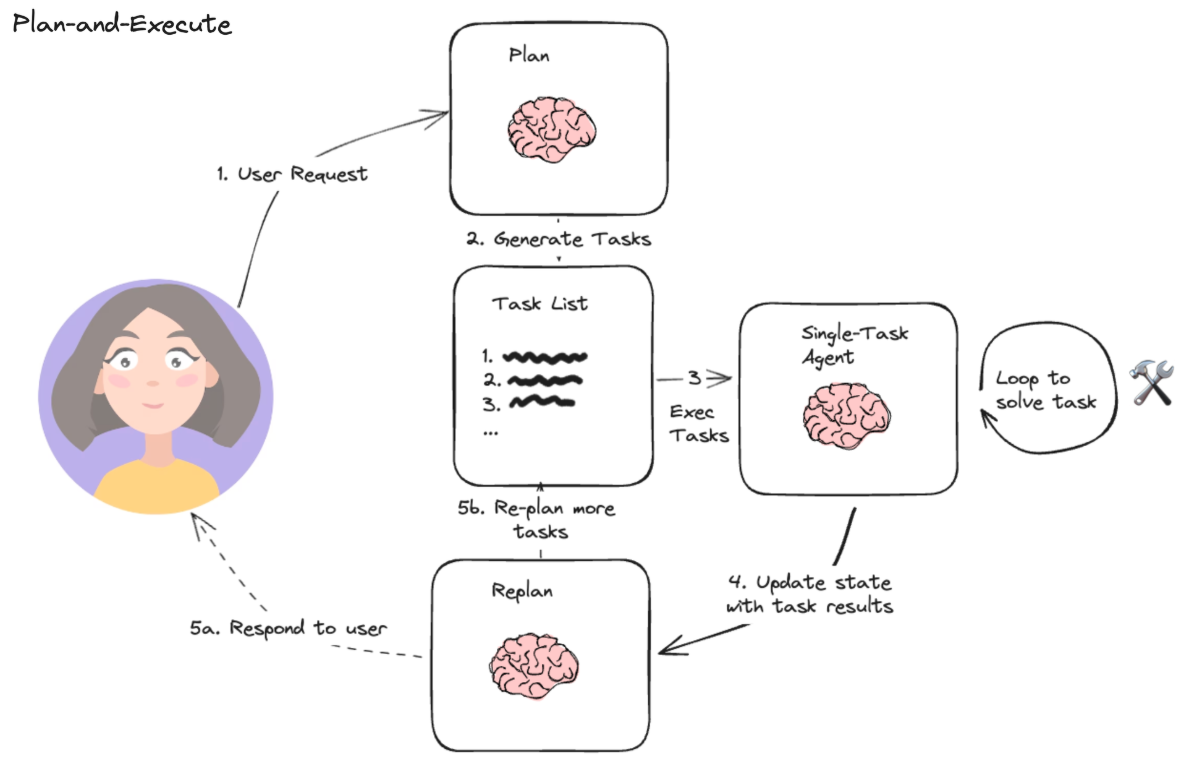

In [31]:
# Import the necessary libraries
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain import hub
from langchain_groq import ChatGroq
from langgraph.prebuilt import create_react_agent
from langchain.document_loaders import WebBaseLoader
from langchain_core.tools import tool
from typing_extensions import Annotated, List, Tuple, TypedDict
import operator
from langchain_core.prompts import ChatPromptTemplate
from typing import Union, Literal
from pydantic import BaseModel, Field
from langgraph.graph import END, START, StateGraph

In [16]:
@tool
def scrape_webpages(urls: List[str]) -> str:
    """Use requests and bs4 to scrape the provided web pages for recent detailed information."""
    loader = WebBaseLoader(web_path=urls)
    docs = loader.load()
    return "\n\n".join(
        [
            f'<Document name="{doc.metadata.get("title","")}">\n{doc.page_content}\n</Document>'
            for doc in docs
        ]
    )

In [ ]:
# Choose the LLM that will drive the agent
llm = ChatGroq(model="llama-3.3-70b-versatile",temperature=0.3)
prompt = "You are a webscraper, scrape the relevant webpages content."
agent_executor = create_react_agent(llm, [scrape_webpages], prompt=prompt)

In [18]:
agent_executor.invoke({"messages":"When next t20 workld is going to happen ?"})

{'messages': [HumanMessage(content='When next t20 workld is going to happen ?', additional_kwargs={}, response_metadata={}, id='82a8bd78-9f97-47d8-b16e-e97f784f0376'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_n0yd', 'function': {'arguments': '{"urls": ["https://www.icc-cricket.com/", "https://www.espncricinfo.com/"]}', 'name': 'scrape_webpages'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 34, 'prompt_tokens': 265, 'total_tokens': 299, 'completion_time': 0.123636364, 'prompt_time': 0.023476465, 'queue_time': 0.057914755, 'total_time': 0.147112829}, 'model_name': 'llama-3.3-70b-versatile', 'system_fingerprint': 'fp_72a5dc99ee', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-6fd8883f-96f6-4d7d-a3bc-08cf4292355e-0', tool_calls=[{'name': 'scrape_webpages', 'args': {'urls': ['https://www.icc-cricket.com/', 'https://www.espncricinfo.com/']}, 'id': 'call_n0yd', 'type': 'tool_call'}], usage_metadata={'input_tokens': 26

In [28]:
# Define the State
class PlanExecute(TypedDict):
    input: str
    plan: List[str]
    past_steps: Annotated[List[Tuple], operator.add]
    response: str

In [29]:
# Define the schema
class Plan(BaseModel):
    """Plan to follow in future"""
    steps: List[str] = Field(
        description="different steps to follow, should be in sorted order"
    )

class Response(BaseModel):
    """Response to user."""
    response: str = Field(description="The response sent to the user")

class Act(BaseModel):
    """Action to perform."""

    action: Union[Response, Plan] = Field(
        description="Action to perform. If you want to respond to user, use Response. "
        "If you need to further use tools to get the answer, use Plan."
    )


In [ ]:
planner_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            """For the given objective, come up with a simple step by step plan. 
            This plan should involve individual tasks, that if executed correctly will yield the correct answer. 
            Do not add any superfluous steps. The result of the final step should be the final answer. 
            Make sure that each step has all the information needed - do not skip steps.""",
        ),
        ("placeholder", "{messages}"),
    ]
)

structured_planner = ChatGroq(model="llama-3.3-70b-versatile",temperature=0.3).with_structured_output(Plan)
planner = planner_prompt | structured_planner

In [25]:
planner.invoke(
    {
        "messages": [
            ("user", "what is the hometown of the current Australia open winner?")
        ]
    }
)

Plan(steps=['Find the current Australia Open winner', 'Find the hometown of the winner'])

In [30]:
replanner_prompt = ChatPromptTemplate.from_template(
    """For the given objective, come up with a simple step by step plan. \
This plan should involve individual tasks, that if executed correctly will yield the correct answer. 
Do not add any superfluous steps. The result of the final step should be the final answer. 
Make sure that each step has all the information needed - do not skip steps.

Your objective was this:
{input}

Your original plan was this:
{plan}

You have currently done the follow steps:
{past_steps}

Update your plan accordingly. If no more steps are needed and you can return to the user, then respond with that. 
Otherwise, fill out the plan. Only add steps to the plan that still NEED to be done. Do not return previously done steps as part of the plan."""
)

strucctured_replanner = ChatGroq(model="llama-3.3-70b-versatile",temperature=0.3).with_structured_output(Act)
replanner = replanner_prompt | strucctured_replanner

In [ ]:
# create the graph
async def execute_step(state: PlanExecute):
    plan = state["plan"]
    plan_str = "\n".join(f"{i+1}. {step}" for i, step in enumerate(plan))
    task = plan[0]
    task_formatted = f"""For the following plan:
{plan_str}\n\nYou are tasked with executing step {1}, {task}."""
    agent_response = await agent_executor.ainvoke(
        {"messages": [("user", task_formatted)]}
    )
    return {
        "past_steps": [(task, agent_response["messages"][-1].content)],
    }